In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

In [15]:
DF = pd.read_excel('PQM dataset.xlsx', sheet_name='RMS_1hr')
print("DataFrame shape:", DF.shape)
# taking only first 13 columns as instructed
DF_first13 = DF.iloc[:,:13]
print("First 13 columns DataFrame shape:", DF_first13.shape)

DataFrame shape: (6005, 52)
First 13 columns DataFrame shape: (6005, 13)


In [16]:
# calculating z-scores for outlier detection
def calc_zscore(column):
    mean = np.mean(column)
    std_dev = np.std(column)

    if std_dev == 0:
        return np.zeros_like(column)
    
    z_scores = (column - mean) / std_dev
    return z_scores

In [17]:
columns = [col for col in DF_first13.columns if col not in ['TimeID']]

z_scores = DF_first13[columns].apply(calc_zscore)

print(z_scores.head())

      Col_1     Col_2     Col_3     Col_4     Col_5     Col_6     Col_7  \
0 -3.848226 -3.822067 -3.853184 -6.059597 -5.950689 -6.060741 -6.066029   
1 -3.848184 -3.824774 -3.852822 -6.059540 -5.950689 -6.060741 -6.066300   
2 -3.848206 -3.817720 -3.853093 -6.059558 -5.950689 -6.060741 -6.066248   
3 -3.847995 -3.822309 -3.853102 -6.059521 -5.948631 -6.060741 -6.066068   
4 -3.847912 -3.817612 -3.852739 -6.059616 -5.950689 -6.060741 -6.066072   

      Col_8     Col_9    Col_10    Col_11    Col_12  
0 -5.960522 -6.062422 -5.335854 -5.417753 -5.414041  
1 -5.960522 -6.062422 -5.337971 -5.417567 -5.414004  
2 -5.960522 -6.062422 -5.332448 -5.417779 -5.414006  
3 -5.960522 -6.061507 -5.335925 -5.417680 -5.413849  
4 -5.960522 -6.061956 -5.332373 -5.417395 -5.413801  


In [18]:
# cleaning data by removing outliers and filling NaN values
outlier_mask = (np.abs(z_scores) > 3).any(axis=1)
print(f"Found {outlier_mask.sum()} outliers in the dataset")

cleanDF = DF_first13 #[~outlier_mask]
cleanDF = cleanDF.fillna(cleanDF.mean())
print("Cleaned DataFrame shape:", cleanDF.shape)

Found 378 outliers in the dataset
Cleaned DataFrame shape: (6005, 13)


In [19]:
# window size = 6 for 12 columns
input_size = 6
power_columns = [col for col in cleanDF.columns if col != 'TimeID']

x_list = []
y_list = []

In [20]:
for i in range(len(power_columns) - input_size):
    input_window = power_columns[i:i + input_size]
    target_column = power_columns[i + input_size]

    x_list.append(cleanDF[input_window].values)
    y_list.append(cleanDF[target_column].values)

In [21]:
x = np.vstack(x_list)
y = np.hstack(y_list)

print("Input shape:", x.shape)
print("Target shape:", y.shape)

Input shape: (36030, 6)
Target shape: (36030,)


In [22]:
split_index = int(0.8 * len(x))

x_train = x[:split_index]
y_train = y[:split_index]

x_test = x[split_index:]
y_test = y[split_index:]

print("Training set shape:", x_train.shape, y_train.shape)
print("Test set shape:", x_test.shape, y_test.shape)

Training set shape: (28824, 6) (28824,)
Test set shape: (7206, 6) (7206,)


In [23]:
model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(x_train, y_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [24]:
# test train split
y_pred = model.predict(x_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Model Performance on Test Set:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-squared (R2): {r2:.4f}")

Model Performance on Test Set:
Mean Absolute Error (MAE): 710.3426
Mean Squared Error (MSE): 2996897.7112
R-squared (R2): 0.9938


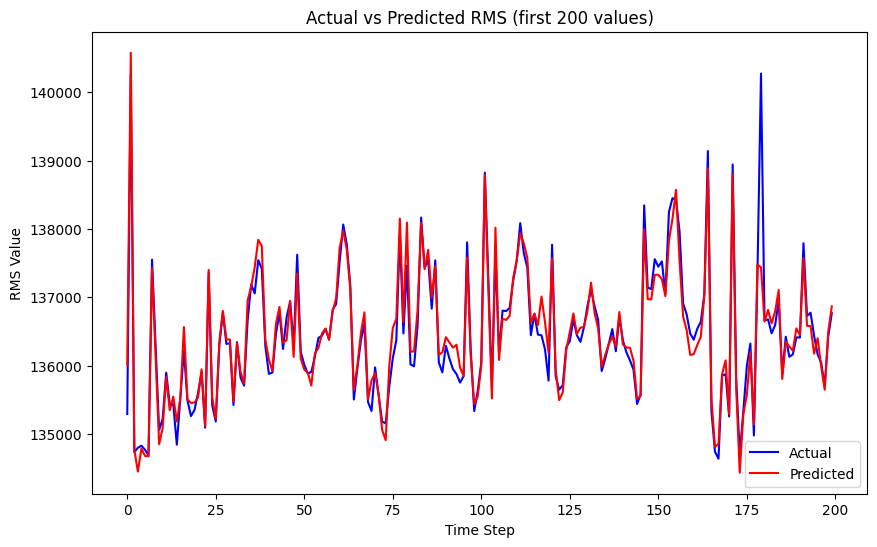

In [25]:
plt.figure(figsize=(10, 6))
plt.plot(y_test[:200], label='Actual', color='blue')
plt.plot(y_pred[:200], label='Predicted', color='red')
plt.title('Actual vs Predicted RMS (first 200 values)')
plt.xlabel('Time Step')
plt.ylabel('RMS Value')
plt.legend()
plt.show()

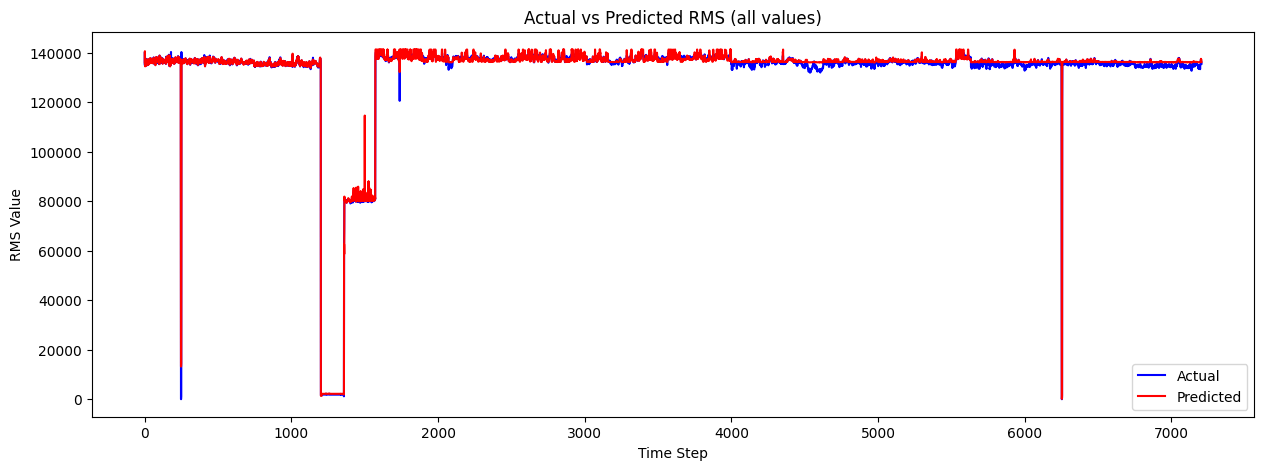

In [26]:
plt.figure(figsize=(15, 5))
plt.plot(y_test, label='Actual', color='blue')
plt.plot(y_pred, label='Predicted', color='red')
plt.title('Actual vs Predicted RMS (all values)')
plt.xlabel('Time Step')
plt.ylabel('RMS Value')
plt.legend()
plt.show()